In [64]:
import json
import os
import sys
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("talk")
sns.set_style('white')
import numpy as np
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import profiler
import single_model_profiles as sm_profs
import end_to_end_profiles as e2e_profiles

## Load Results

In [67]:
tf_results = e2e_profiles.load_tfserving_end_to_end("image_driver_1")
single_proc_results = e2e_profiles.load_pipeline_one_single_proc()
paths = {
    "Latency Greedy": "../results/e2e_profs/systemx/image_driver_1/min_latency",
    "Throughput Greedy": "../results/e2e_profs/systemx/image_driver_1/max_throughput",
    "500ms SLO": "../results/e2e_profs/systemx/image_driver_1/500ms",
    "1000ms SLO": "../results/e2e_profs/systemx/image_driver_1/1000ms"    
}

dfs = []
for name, path in paths.items():
    dfs.append(e2e_profiles.load_end_to_end_experiment(name, path)[0])
system_x_results = pd.concat(dfs)

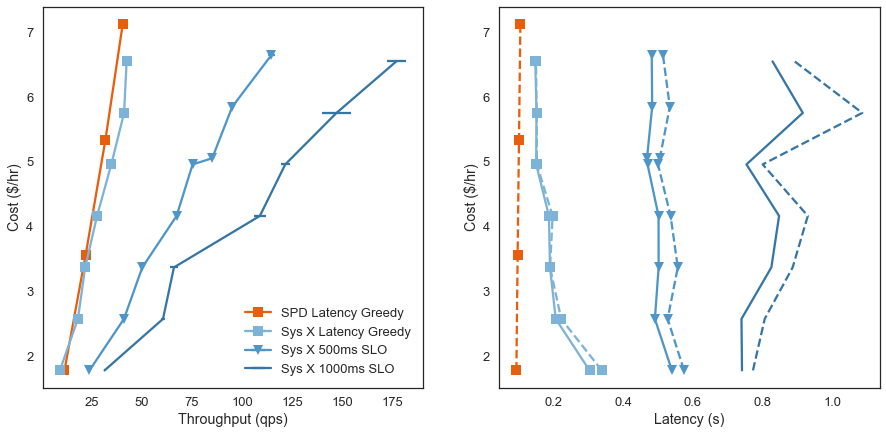

In [71]:
def plot_cost_comp(sys_x, spd):
    plt.clf()
    fig, (ax_thru, ax_lat) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
#     colors = sns.color_palette()
    markers = {
        "Latency Greedy": "s",
        "Throughput Greedy": "o",
        "500ms SLO": "v",
        "1000ms SLO": "+"
    }
    
    def plot_system_x():
        colors = sns.color_palette("Blues_d", n_colors=4)
        # Plot the System X results
        for exp in ["Latency Greedy", "500ms SLO", "1000ms SLO"]:
            c = colors.pop()
            df = sys_x[(sys_x.name == exp)]
            df = df.sort_values('cost')
            m = markers[exp]
            ax_thru.errorbar(df["mean_throughput"], df['cost'], xerr=df["standard_dev_throughput"], label="Sys X {}".format(exp), marker=m, color=c)
            ax_lat.plot(df['p99_latency'], df["cost"], linestyle="--", color=c, marker=m, label="{}_p99".format(exp))
            ax_lat.plot(df['p95_latency'], df["cost"], linestyle="-", color=c, marker=m, label="{}_p95".format(exp))
    
    def plot_spd():
        colors = sns.color_palette("Oranges", n_colors=2)
        for exp in ["Latency Greedy"]:
            c = colors.pop()
            df = spd[(spd.name == exp)]
            df = df.sort_values('cost')
            m = markers[exp]
            ax_thru.plot(df["mean_throughput"], df['cost'], label="SPD {}".format(exp), marker=m, color=c)
            ax_lat.plot(df['p99_latency'], df["cost"], linestyle="--", color=c, marker=m, label="{}_p99".format(exp))
    
    plot_system_x()
    plot_spd()
    ax_thru.set_xlabel("Throughput (qps)")
    ax_thru.set_ylabel("Cost ($/hr)")
    ax_lat.set_xlabel("Latency (s)")
    ax_lat.set_ylabel("Cost ($/hr)")
#     ax_lat.set_ticks(np.arange(0.0, 6.0, 0.5))
    ax_thru.legend()
#     ax_lat.legend()
    plt.show
plot_cost_comp(system_x_results, single_proc_results)

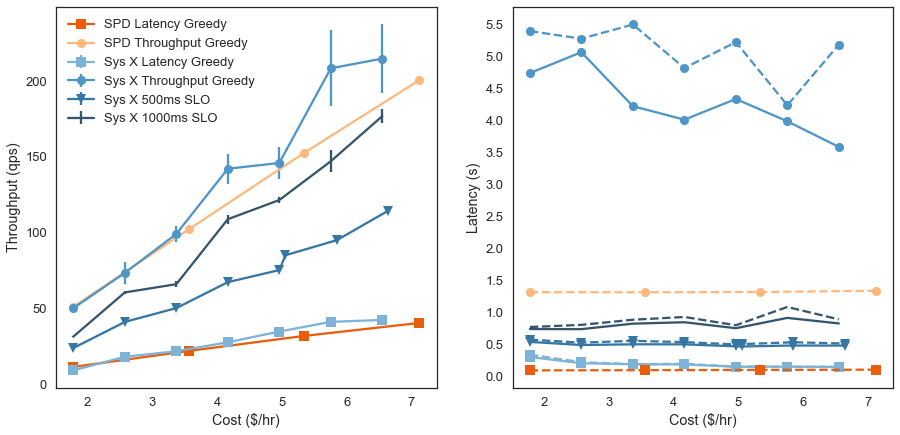

In [69]:
def plot_sys_comp(sys_x, tfs, spd):
    plt.clf()
    fig, (ax_thru, ax_lat) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
#     colors = sns.color_palette()
    markers = {
        "Latency Greedy": "s",
        "Throughput Greedy": "o",
        "500ms SLO": "v",
        "1000ms SLO": "+"
    }
    
    def plot_system_x():
        colors = sns.color_palette("Blues_d", n_colors=4)
        # Plot the System X results
        for exp in ["Latency Greedy", "Throughput Greedy", "500ms SLO", "1000ms SLO"]:
            c = colors.pop()
            df = sys_x[(sys_x.name == exp)]
            df = df.sort_values('cost')
            m = markers[exp]
            ax_thru.errorbar(df['cost'], df["mean_throughput"], yerr=df["standard_dev_throughput"], label="Sys X {}".format(exp), marker=m, color=c)
            ax_lat.plot(df["cost"], df['p99_latency'], linestyle="--", color=c, marker=m, label="{}_p99".format(exp))
            ax_lat.plot(df["cost"], df['p95_latency'], linestyle="-", color=c, marker=m, label="{}_p95".format(exp))
    
    def plot_tf_serving():
        colors = sns.color_palette("Greens_d", n_colors=2)
        for exp in ["Latency Greedy", "Throughput Greedy"]:
            c = colors.pop()
            df = tfs[(tfs.name == exp)]
            df = df.sort_values('cost')
            m = markers[exp]
            ax_thru.errorbar(df['cost'], df["mean_throughput"], yerr=df["standard_dev_throughput"], label="TFS {}".format(exp), marker=m, color=c)
            ax_lat.plot(df["cost"], df['p99_latency'], linestyle="--", color=c, marker=m, label="{}_p99".format(exp))
            ax_lat.plot(df["cost"], df['p95_latency'], linestyle="-", color=c, marker=m, label="{}_p95".format(exp))
    
    def plot_spd():
        colors = sns.color_palette("Oranges", n_colors=2)
        for exp in ["Latency Greedy", "Throughput Greedy"]:
            c = colors.pop()
            df = spd[(spd.name == exp)]
            df = df.sort_values('cost')
            m = markers[exp]
            ax_thru.plot(df['cost'], df["mean_throughput"], label="SPD {}".format(exp), marker=m, color=c)
            ax_lat.plot(df["cost"], df['p99_latency'], linestyle="--", color=c, marker=m, label="{}_p99".format(exp))
    
    plot_system_x()
#     plot_tf_serving()
    plot_spd()
    ax_thru.set_ylabel("Throughput (qps)")
    ax_thru.set_xlabel("Cost ($/hr)")
    ax_lat.set_ylabel("Latency (s)")
    ax_lat.set_xlabel("Cost ($/hr)")
    ax_lat.set_yticks(np.arange(0.0, 6.0, 0.5))
    ax_thru.legend()
#     ax_lat.legend()
    plt.show()
plot_sys_comp(system_x_results, tf_results, single_proc_results)

In [10]:
system_x_results

,config,cost,latency,mean_throughput,name,p95_latency,p99_latency,standard_dev_throughput
0,"[{'model_image': 'model-comp/inception-feats',...",1.780,"[0.227315, 0.227297, 0.227298, 0.227292, 0.231...",8.981351,min,0.303895,0.338989,0.012361
1,"[{'model_image': 'model-comp/inception-feats',...",2.575,"[0.170273, 0.193659, 0.178213, 0.18726, 0.1720...",17.996296,min,0.207015,0.222596,0.040983
2,"[{'model_image': 'model-comp/inception-feats',...",3.370,"[0.190168, 0.190634, 0.188866, 0.188381, 0.189...",21.613426,min,0.190506,0.190738,0.002455
3,"[{'model_image': 'model-comp/inception-feats',...",4.165,"[0.148801, 0.185011, 0.162089, 0.150393, 0.185...",27.556654,min,0.187472,0.197995,0.088119
4,"[{'model_image': 'model-comp/inception-feats',...",4.960,"[0.148017, 0.149288, 0.147643, 0.148547, 0.149...",34.642287,min,0.150855,0.152941,0.012244
5,"[{'model_image': 'model-comp/inception-feats',...",5.755,"[0.150417, 0.149596, 0.150804, 0.150874, 0.151...",41.044612,min,0.151871,0.152325,0.015181
6,"[{'model_image': 'model-comp/inception-feats',...",6.550,"[0.146667, 0.14643, 0.146213, 0.14511, 0.14704...",42.304520,min,0.148325,0.150225,0.017019
0,"[{'model_image': 'model-comp/inception-feats',...",1.780,"[3.000922, 3.757672, 2.858535, 4.709379, 4.570...",50.050566,max,4.746262,5.402978,2.472298
1,"[{'model_image': 'model-comp/inception-feats',...",2.575,"[4.063737, 4.007427, 4.845475, 4.739211, 4.619...",73.396647,max,5.073463,5.284790,7.132579
2,"[{'model_image': 'model-comp/inception-feats',...",3.370,"[3.623324, 3.528618, 3.608548, 3.499109, 3.588...",99.114521,max,4.228344,5.506849,5.380199


In [39]:
tf_results

,config,cost,latency,mean_throughput,name,p95_latency,p99_latency,standard_dev_throughput
0,"[{'name': 'inception', 'cpus_per_replica': 2, ...",1.780,"[1.937485, 1.633534, 1.57419, 1.807961, 1.6507...",36.374484,Throughput Greedy,2.091432,2.338587,0.388441
1,"[{'name': 'inception', 'cpus_per_replica': 2, ...",2.575,"[1.036986, 0.944567, 1.179942, 0.952674, 1.221...",63.707063,Throughput Greedy,2.326371,2.746335,0.924452
2,"[{'name': 'inception', 'cpus_per_replica': 2, ...",3.370,"[2.11279, 1.819615, 1.575978, 1.874477, 1.4395...",74.162492,Throughput Greedy,2.201037,2.693825,1.303273
3,"[{'name': 'inception', 'cpus_per_replica': 2, ...",4.165,"[2.752776, 2.826466, 2.770004, 3.20376, 2.6411...",95.734762,Throughput Greedy,2.998077,3.481123,2.422248
4,"[{'name': 'inception', 'cpus_per_replica': 2, ...",4.960,"[1.359936, 1.087656, 1.427561, 1.439654, 1.348...",111.482119,Throughput Greedy,2.858963,3.169423,2.500371
5,"[{'name': 'inception', 'cpus_per_replica': 2, ...",5.755,"[2.734466, 2.611775, 2.173062, 2.272713, 2.121...",144.081378,Throughput Greedy,2.409329,2.603621,2.407381
6,"[{'name': 'inception', 'cpus_per_replica': 2, ...",6.550,"[1.832582, 1.419666, 2.155309, 1.530251, 1.668...",169.438223,Throughput Greedy,2.424474,2.708744,3.296158
0,"[{'name': 'inception', 'cpus_per_replica': 2, ...",1.780,"[0.151502, 0.152282, 0.162672, 0.144447, 0.140...",11.008765,Latency Greedy,0.162552,0.172026,0.011127
1,"[{'name': 'inception', 'cpus_per_replica': 2, ...",2.575,"[0.146687, 0.166929, 0.146345, 0.14484, 0.1327...",21.328060,Latency Greedy,0.147641,0.158785,0.037833
2,"[{'name': 'inception', 'cpus_per_replica': 2, ...",3.370,"[0.144658, 0.142439, 0.144716, 0.13849, 0.1696...",22.081307,Latency Greedy,0.158368,0.168808,0.059065


In [45]:
single_proc_results

,cost,mean_latency,mean_throughput,name,num_replicas,p99_latency
0,1.78,1.254965,50.996051,Throughput Greedy,1,1.317782
1,3.56,1.253951,102.079373,Throughput Greedy,2,1.315854
2,5.34,1.258829,152.528221,Throughput Greedy,3,1.320939
3,7.12,1.275789,200.661499,Throughput Greedy,4,1.340525
0,1.78,0.088596,11.279907,Latency Greedy,1,0.094103
1,3.56,0.091559,21.830169,Latency Greedy,2,0.097656
2,3.56,0.094944,21.055443,Latency Greedy,2,0.101862
3,5.34,0.099293,30.195652,Latency Greedy,3,0.105617
